In [1]:
import numpy as np
import pandas as pd # 엑셀 파일 읽어오고 전처리
import matplotlib.pyplot as pl # 그래프 도시
import tensorflow as tf # 텐서플로우로 모델 구현
from tensorflow import keras
from keras import models, layers
from keras.callbacks import ModelCheckpoint # 학습한 모델 저장(체크포인트)

c:\Users\deep\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
data = pd.read_csv('180801_RFB_510cy_006_DC.csv') # RFB 충방전 사이클 데이터
data = data.drop(['시험_시간(s)', '사이클_번호', '사이클_시간(s)', '단계_번호', '단계_시간(s)', '인덱스', '보조전압1(V)', '보조전압2(V)', '보조전압3(V)', '온도(\'C)', '전류_범위', 'OCP(V)', '파워(W)', '부하(Ohm)', '누적_용량(Ah)', '절대값_용량(Ah)'], axis = 1)
# 필요 없는 데이터 drop
data_voltage = data.copy() 
data_voltage = data_voltage.pop('전압(V)') # 전압 데이터(SOC)만 남기고 정답 데이터로 가공

data rows = 262407
Index(['전류(A)', '전압(V)'], dtype='object')
x = (262407, 2)
y = (262407,)


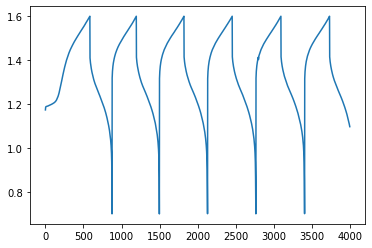

In [3]:
print(f'data rows = {data.shape[0]}')
print(data.columns)
data = data.values
print(f'x = {data.shape}') # 262407개 데이터
print(f'y = {data_voltage.shape}')

# for index in range(data.shape[0]):
#     data[index, 0] = int(data[index, 0][3:5]) * 60 + int(data[index, 0][6:8])
#     data[index, 2] = int(data[index, 2][3:5]) * 60 + int(data[index, 2][6:8])
#     data[index, 4] = int(data[index, 4][3:5]) * 60 + int(data[index, 4][6:8])
pl.plot(data_voltage[:4000])

<h1>데이터 전처리</h1>

In [4]:
seq_len = 200 # 시퀀스 길이 = 200
num_batch = int(np.floor(data.shape[0] / seq_len))
print(f'num_batch = {num_batch}')
x_data = []
y_data = []
for batch in range(num_batch):
    # 데이터를 시퀀스 길이로 나누어 시퀀스 단위로 입력시키기 위한 가공
    x_data.append(data[batch * seq_len:(batch + 1) * seq_len])
    y_data.append(data_voltage[batch * seq_len + 1:(batch + 1) * seq_len + 1]) # t + 1 시점의 전압을 저장 -> y_data
x_data = np.array(x_data).astype(np.float32)
y_data = np.array(y_data).astype(np.float32) # 텐서플로 모델은 실수 자료형 넘파이 배열을 입출력으로 사용
print(f'x = {x_data.shape}')
print(f'y = {y_data.shape}')
print(x_data[0, 0:6, 1])
print(y_data[0, 0:5])

num_batch = 1312
x = (1312, 200, 2)
y = (1312, 200)
[1.173039  1.1802392 1.18315   1.184682  1.1857544 1.1868268]
[1.1802392 1.18315   1.184682  1.1857544 1.1868268]


<h1>학습 데이터, 실험 데이터로 분리</h1>

In [5]:
split_len = int(round(num_batch * 0.75))
print(split_len)
x_train = x_data[:split_len]
y_train = y_data[:split_len]
x_test = x_data[split_len:]
y_test = y_data[split_len:]
print(y_train.shape)

## 데이터 전처리 끝

984
(984, 200)


In [6]:
loss_dict = {} # 손실 함수 값을 저장할 딕셔너리 선언
num_units = 256 # LSTM 유닛 수
num_epochs = 30 # 에포크 수
batch_size = 123 # 배치 크기
epoch_index = 0
model = models.Sequential() # 선언 순서대로 층을 쌓는 시퀀셜 모델 선언
model.add(layers.LSTM(num_units, input_shape=(None, x_train.shape[2]), return_sequences=True)) 
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(num_units, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.TimeDistributed(layers.Dense(1)))
model.compile(loss = 'mse', optimizer = 'Adam')
model.summary() # 모델 구현 후 컴파일한 뒤 모델 구조 요약 출력

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 256)         265216    
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 lstm_1 (LSTM)               (None, None, 256)         525312    
                                                                 
 dropout_1 (Dropout)         (None, None, 256)         0         
                                                                 
 time_distributed (TimeDistr  (None, None, 1)          257       
 ibuted)                                                         
                                                                 
Total params: 790,785
Trainable params: 790,785
Non-trainable params: 0
__________________________________________________

In [7]:
epoch_index += num_epochs
callback_list = [ModelCheckpoint(filepath = f'Checkpoints\SOC_Checkpoint_{epoch_index}.h5', monitor = 'val_loss', save_best_only = True)]
fitdata = model.fit(x_train, y_train, epochs=num_epochs, verbose = 1, validation_split=1/8, callbacks=callback_list, batch_size=batch_size)

Epoch 1/30
7/7 [==============================] - 5s 129ms/step - loss: 0.4336 - val_loss: 0.1121
Epoch 2/30
7/7 [==============================] - 0s 53ms/step - loss: 0.0687 - val_loss: 0.0330
Epoch 3/30
7/7 [==============================] - 0s 54ms/step - loss: 0.0447 - val_loss: 0.0287
Epoch 4/30
7/7 [==============================] - 0s 55ms/step - loss: 0.0350 - val_loss: 0.0279
Epoch 5/30
7/7 [==============================] - 0s 55ms/step - loss: 0.0307 - val_loss: 0.0250
Epoch 6/30
7/7 [==============================] - 0s 53ms/step - loss: 0.0278 - val_loss: 0.0243
Epoch 7/30
7/7 [==============================] - 0s 53ms/step - loss: 0.0260 - val_loss: 0.0224
Epoch 8/30
7/7 [==============================] - 0s 53ms/step - loss: 0.0246 - val_loss: 0.0216
Epoch 9/30
7/7 [==============================] - 0s 54ms/step - loss: 0.0235 - val_loss: 0.0201
Epoch 10/30
7/7 [==============================] - 0s 53ms/step - loss: 0.0225 - val_loss: 0.0193
Epoch 11/30
7/7 [===========

In [8]:
model.load_weights(f'Checkpoints\SOC_Checkpoint_{epoch_index}.h5')
# 모델 1차 검증
loss = model.evaluate(x_test, y_test)
loss_dict[f'loss_{epoch_index}'] = loss # 딕셔너리에 현 에포크까지의 손실 함수 값 저장
prediction = model.predict(x_test) # 현 상태에서 추론
prediction = prediction.reshape(int(prediction.shape[0] * prediction.shape[1]), 1) # 추론 값은 시퀀스 단위로 나뉘어 있으므로 1차원 데이터로 가공
y_graph = y_test.reshape(int(y_test.shape[0] * y_test.shape[1]), 1) # y_test 데이터 역시 1차원 데이터로 가공
print(prediction.shape, y_graph.shape)

11/11 [==============================] - 0s 8ms/step
(65600, 1) (65600, 1)


256 units, 30 epochs, sequence length = 200


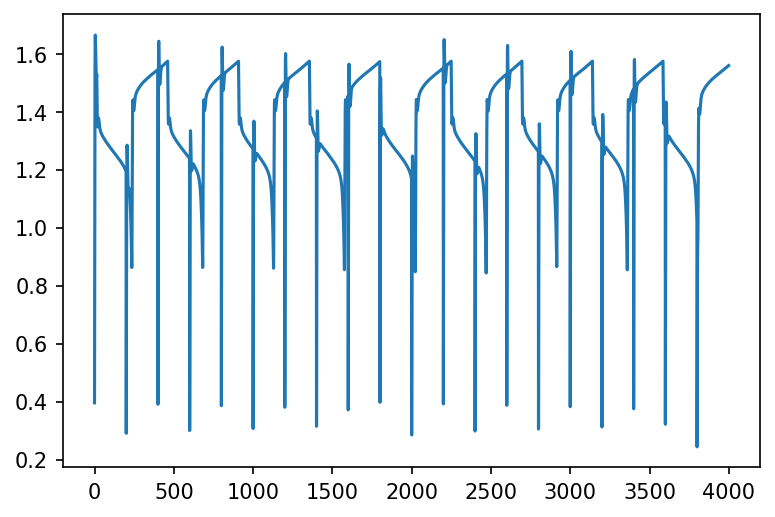

In [9]:
print(f'{num_units} units, {epoch_index} epochs, sequence length = {seq_len}')
pl.figure(dpi=150) # 해상도(default = 100)
pl.plot(prediction[:4000])

In [10]:
epoch_index += num_epochs
callback_list = [ModelCheckpoint(filepath = f'Checkpoints\SOC_Checkpoint_{epoch_index}.h5', monitor = 'val_loss', save_best_only = True)]
fitdata = model.fit(x_train, y_train, epochs=num_epochs, verbose = 0, validation_split=1/8, callbacks=callback_list, batch_size=batch_size)

In [11]:
model.load_weights(f'Checkpoints\SOC_Checkpoint_{epoch_index}.h5')
loss = model.evaluate(x_test, y_test)
loss_dict[f'loss_{epoch_index}'] = loss
prediction = model.predict(x_test)
prediction = prediction.reshape(int(prediction.shape[0] * prediction.shape[1]), 1)
y_graph = y_test.reshape(int(y_test.shape[0] * y_test.shape[1]), 1)
print(prediction.shape, y_graph.shape)

11/11 [==============================] - 0s 9ms/step
(65600, 1) (65600, 1)


256 units, 60 epochs, sequence length = 200


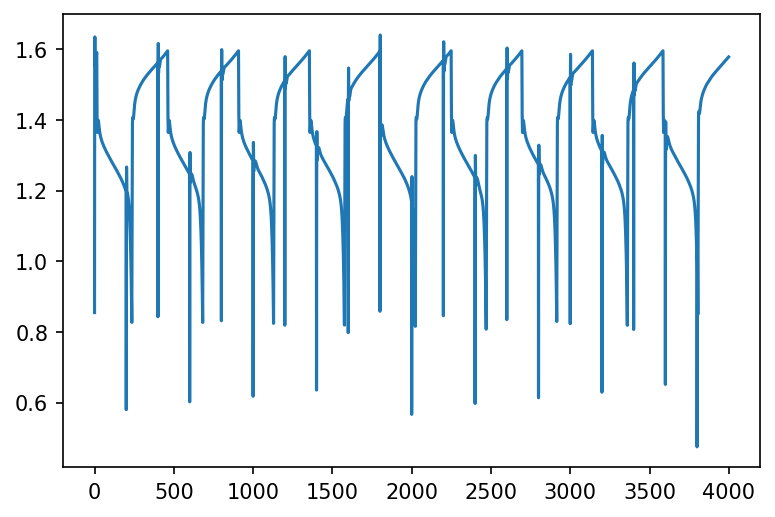

In [12]:
print(f'{num_units} units, {epoch_index} epochs, sequence length = {seq_len}')
pl.figure(dpi=150)
pl.plot(prediction[:4000])

In [13]:
epoch_index += num_epochs
callback_list = [ModelCheckpoint(filepath = f'Checkpoints\SOC_Checkpoint_{epoch_index}.h5', monitor = 'val_loss', save_best_only = True)]
fitdata = model.fit(x_train, y_train, epochs=num_epochs, verbose = 0, validation_split=1/8, callbacks=callback_list, batch_size=batch_size)

In [14]:
model.load_weights(f'Checkpoints\SOC_Checkpoint_{epoch_index}.h5')
loss = model.evaluate(x_test, y_test)
loss_dict[f'loss_{epoch_index}'] = loss
prediction = model.predict(x_test)
prediction = prediction.reshape(int(prediction.shape[0] * prediction.shape[1]), 1)
y_graph = y_test.reshape(int(y_test.shape[0] * y_test.shape[1]), 1)
print(prediction.shape, y_graph.shape)

11/11 [==============================] - 0s 8ms/step
(65600, 1) (65600, 1)


256 units, 90 epochs, sequence length = 200


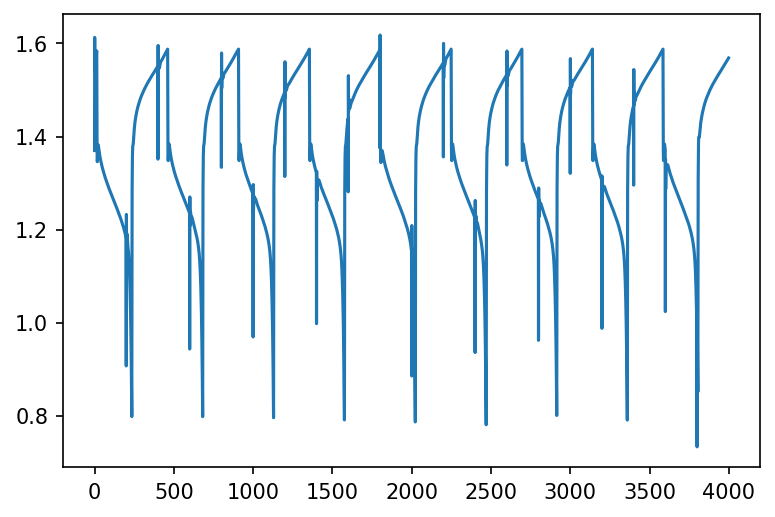

In [15]:
print(f'{num_units} units, {epoch_index} epochs, sequence length = {seq_len}')
pl.figure(dpi=150)
pl.plot(prediction[:4000])

In [16]:
epoch_index += num_epochs
callback_list = [ModelCheckpoint(filepath = f'Checkpoints\SOC_Checkpoint_{epoch_index}.h5', monitor = 'val_loss', save_best_only = True)]
fitdata = model.fit(x_train, y_train, epochs=num_epochs, verbose = 0, validation_split=1/8, callbacks=callback_list, batch_size=batch_size)

In [17]:
model.load_weights(f'Checkpoints\SOC_Checkpoint_{epoch_index}.h5')
loss = model.evaluate(x_test, y_test)
loss_dict[f'loss_{epoch_index}'] = loss
prediction = model.predict(x_test)
prediction = prediction.reshape(int(prediction.shape[0] * prediction.shape[1]), 1)
y_graph = y_test.reshape(int(y_test.shape[0] * y_test.shape[1]), 1)
print(prediction.shape, y_graph.shape)

11/11 [==============================] - 0s 8ms/step
(65600, 1) (65600, 1)


256 units, 120 epochs, sequence length = 200


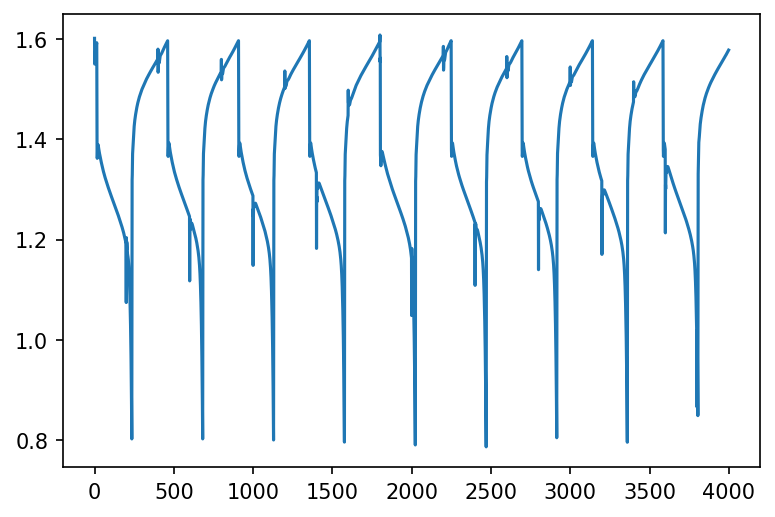

In [18]:
print(f'{num_units} units, {epoch_index} epochs, sequence length = {seq_len}')
pl.figure(dpi=150)
pl.plot(prediction[:4000])

In [19]:
epoch_index += num_epochs
callback_list = [ModelCheckpoint(filepath = f'Checkpoints\SOC_Checkpoint_{epoch_index}.h5', monitor = 'val_loss', save_best_only = True)]
fitdata = model.fit(x_train, y_train, epochs=num_epochs, verbose = 0, validation_split=1/8, callbacks=callback_list, batch_size=batch_size)

In [20]:
model.load_weights(f'Checkpoints\SOC_Checkpoint_{epoch_index}.h5')
loss = model.evaluate(x_test, y_test)
loss_dict[f'loss_{epoch_index}'] = loss
prediction = model.predict(x_test)
prediction = prediction.reshape(int(prediction.shape[0] * prediction.shape[1]), 1)
y_graph = y_test.reshape(int(y_test.shape[0] * y_test.shape[1]), 1)
print(prediction.shape, y_graph.shape)
print(f'{num_units} units, {epoch_index} epochs, sequence length = {seq_len}')

11/11 [==============================] - 0s 8ms/step
(65600, 1) (65600, 1)
256 units, 150 epochs, sequence length = 200


{'loss_30': 0.010174689814448357, 'loss_60': 0.0037280768156051636, 'loss_90': 0.001498688361607492, 'loss_120': 0.0010824929922819138, 'loss_150': 0.0010083302622660995}


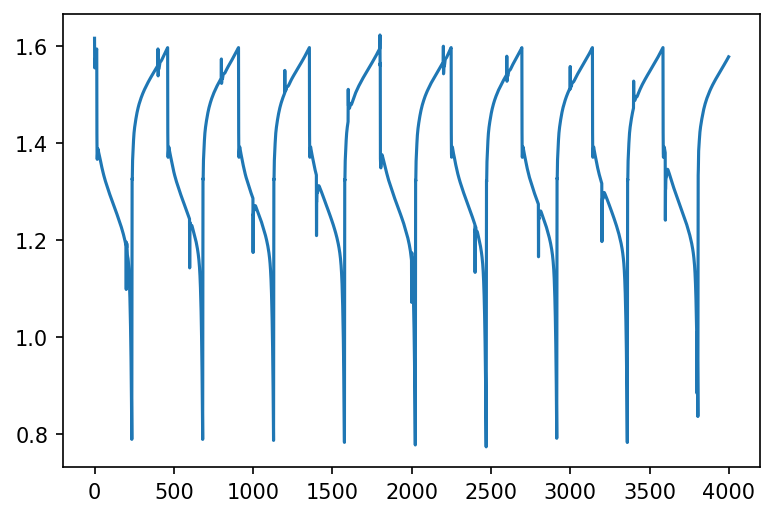

In [21]:
pl.figure(dpi=150)
pl.plot(prediction[:4000])
print(loss_dict)